# Sprint 3 - Data Integration & Cleaning Notebook
**Emily Nguyen, Kaylynn Francisco-Nelson, Angela Iraya**

### LA Hospital Dataset Exploration
---

The Points of Interest Hospitals dataset is maintained by the Los Angeles County Internal Services Department, Enterprise GIS Section. The dataset is part of the LA County’s “Points of Interest” collection and provides geolocated information on hospitals and related health facilities across LA, which will help us integrate contextual healthcare accessibility data into our main sexual crimes dataset. Access to hospitals may provide insights into emergency response times, healthcare proximity, or victim outcomes.

The hospital dataset contains 93 hospital records. Some of the key variables in the dataset include: 
- Facility Information: FACNAME, BUSINESS_NAME, FAC_TYPE_CODE, FAC_STATUS_TYPE_CODE, CAPACITY
- Location Data: ADDRESS, CITY, ZIP Code, LATITUDE, LONGITUDE
- Administrative Fields: LICENSE_NUMBER, LICENSE_STATUS_DESCRIPTION, DISTRICT_NAME, COUNTY_NAME
- Healthcare Attributes: BIRTHING_FACILITY_FLAG, TRAUMA_CTR, CRITICAL_ACCESS_HOSPITAL

In [77]:
# Import modules
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import requests
import zipfile
import os

In [78]:
# Uploaded data from new Hospital dataset
df = pd.read_csv("../data/Points_of_Interest_Hospitals.csv") 
df.head()

,OBJECTID,City,ZIP Code,LICENSED_CERTIFIED,FLAG,T18_19,FACID,FAC_STATUS_TYPE_CODE,ASPEN_FACID,CCN,...,CCLHO_NAME,FIPS_COUNTY_CODE,BIRTHING_FACILITY_FLAG,TRAUMA_PED_CTR,TRAUMA_CTR,TYPE_OF_CARE,CRITICAL_ACCESS_HOSPITAL,DATA_DATE,x,y
0,122506,TORRANCE,90502,LICENSED AND CERTIFIED,NaN,NaN,60000027,OPEN,CA060000027,50376.0,...,LOS ANGELES,6037,YES,LEVEL II PED,LEVEL I,NaN,NaN,2025-03-17T00:00:00,6.472977e+06,1.760762e+06
1,122507,DOWNEY,90242,LICENSED AND CERTIFIED,NaN,NaN,60000028,OPEN,CA060000028,50717.0,...,LOS ANGELES,6037,NaN,NaN,NaN,NaN,NaN,2025-03-17T00:00:00,6.513737e+06,1.796618e+06
2,122508,LOS ANGELES,90059,LICENSED AND CERTIFIED,NaN,NaN,60000035,OPEN,CA06000035,50779.0,...,LOS ANGELES,6037,YES,NaN,NaN,NaN,NaN,2025-03-17T00:00:00,6.487597e+06,1.794882e+06
3,122509,SYLMAR,91342,LICENSED AND CERTIFIED,NaN,NaN,60000038,OPEN,CA060000038,50040.0,...,LOS ANGELES,6037,YES,NaN,NaN,NaN,NaN,2025-03-17T00:00:00,6.425291e+06,1.941683e+06
4,122510,LOS ANGELES,90033,LICENSED AND CERTIFIED,NaN,NaN,60000040,OPEN,CA060000040,50373.0,...,LOS ANGELES,6037,YES,LEVEL II PED,LEVEL I,NaN,NaN,2025-03-17T00:00:00,6.499125e+06,1.842927e+06


In [79]:
# look at columns in Hospital dataset
df.columns.unique()

Index(['OBJECTID', 'City', 'ZIP Code', 'LICENSED_CERTIFIED', 'FLAG', 'T18_19',
       'FACID', 'FAC_STATUS_TYPE_CODE', 'ASPEN_FACID', 'CCN', 'TERMINAT_SW',
       'PARTICIPATION_DATE', 'APPROVAL_DATE', 'NPI', 'CAN_BE_DEEMED_FAC_TYPE',
       'CAN_BE_CERTIFIED_FAC_TYPE', 'DEEMED', 'AO_CD', 'DMG_EFCTV_DT',
       'AO_TRMNTN_DT', 'AO_NAME', 'FACNAME', 'FAC_TYPE_CODE', 'FAC_FDR', 'LTC',
       'CAPACITY', 'ADDRESS', 'ZIP9', 'FACADMIN', 'CONTACT_EMAIL',
       'CONTACT_FAX', 'CONTACT_PHONE_NUMBER', 'COUNTY_CODE', 'COUNTY_NAME',
       'DISTRICT_NUMBER', 'DISTRICT_NAME', 'ISFACMAIN', 'PARENT_FACID',
       'FAC_FAC_RELATIONSHIP_TYPE_CODE', 'START_DATE', 'LICENSE_NUMBER',
       'BUSINESS_NAME', 'LICENSE_STATUS_DESCRIPTION', 'INITIAL_LICENSE_DATE',
       'LICENSE_EFFECTIVE_DATE', 'LICENSE_EXPIRATION_DATE',
       'ENTITY_TYPE_DESCRIPTION', 'LATITUDE', 'LONGITUDE', 'LOCATION',
       'HCAI_ID', 'CCLHO_CODE', 'CCLHO_NAME', 'FIPS_COUNTY_CODE',
       'BIRTHING_FACILITY_FLAG', 'TRAUMA_PED_CTR', 

**Initial Observations**:

The dataset contains over 60 columns, however in our case we would likely only need to use a few of the features. 
Key observations so far:
- Some columns (e.g., x, y, LATITUDE, LONGITUDE) provide location data.
- Others like FAC_STATUS_TYPE_CODE, TYPE_OF_CARE, and TRAUMA_CTR describe each facility’s services.
- ZIP Code or LATITUTDE/LONGITUDE appear to be the most useful for linking to our crime dataset, which also includes location data such at "LAT/LON."

In [80]:
df['City'].unique()

array(['TORRANCE', 'DOWNEY', 'LOS ANGELES', 'SYLMAR', 'WEST HOLLYWOOD',
       'ALHAMBRA', 'LANCASTER', 'MONTEBELLO', 'AVALON', 'CULVER CITY',
       'BELLFLOWER', 'POMONA', 'INGLEWOOD', 'PASADENA', 'PANORAMA CITY',
       'WEST HILLS', 'PARAMOUNT', 'DUARTE', 'NORWALK', 'GARDENA',
       'HUNTINGTON PARK', 'SAN GABRIEL', 'WEST COVINA', 'MARINA DEL REY',
       'LAKEWOOD', 'SANTA MONICA', 'ENCINO', 'GLENDORA', 'MONTEREY PARK',
       'GLENDALE', 'SOUTH EL MONTE', 'VALENCIA', 'MISSION HILLS',
       'COVINA', 'HARBOR CITY', 'PALMDALE', 'LA MIRADA', 'TARZANA',
       'LONG BEACH', 'ARCADIA', 'WHITTIER', 'BURBANK', 'MONROVIA',
       'NORTHRIDGE', 'SAN DIMAS', 'LYNWOOD', 'VAN NUYS', 'SUN VALLEY',
       'SHERMAN OAKS', 'BALDWIN PARK', 'SAN PEDRO', 'WOODLAND HILLS'],
      dtype=object)

Variables like T18_T19 and TYPE_OF_CARE, may not be useful to include in our analyses, as there are only 93 records in our dataset and those 2 columns have all records missing.

In [81]:
# View data types and missing values per column
df.isna().sum().sort_values(ascending=False).head(10)

TYPE_OF_CARE                93
T18_19                      93
TERMINAT_SW                 92
CRITICAL_ACCESS_HOSPITAL    92
AO_TRMNTN_DT                91
FLAG                        88
TRAUMA_PED_CTR              85
START_DATE                  84
PARENT_FACID                84
TRAUMA_CTR                  78
dtype: int64

**Key Variables Kept for Analyses**: 
- ZIP Code: Postal area of the hospital, could be used for spatial visualization later
- City: City where the facility is located, secondary spatial identifier
- FAC_STATUS_TYPE_CODE: Operational status (e.g., OPEN, CLOSED), indicates active healthcare coverage
- TRAUMA_CTR: Trauma care level (e.g., Level I, II), reflects emergency service capacity
- BIRTHING_FACILITY_FLAG: Indicates birthing facility availability, relevant for gender-related healthcare accessibility
- CRITICAL_ACCESS_HOSPITAL: Marks federally designated rural emergency hospitals, adds rural–urban healthcare context
- LATITUDE / LONGITUDE: Facility coordinates, used for joining datasets
- COUNTY_NAME: County in which the hospital is located, supports geographic summaries

In [82]:
# Only keeping useful columns
key_vars = [
    "FACNAME",
    "City",
    "ZIP Code",
    "FAC_STATUS_TYPE_CODE",
    "TRAUMA_CTR",
    "BIRTHING_FACILITY_FLAG",
    "CRITICAL_ACCESS_HOSPITAL",
    "LATITUDE",
    "LONGITUDE",
    "COUNTY_NAME"
]

df = df[key_vars]
df.head()

,FACNAME,City,ZIP Code,FAC_STATUS_TYPE_CODE,TRAUMA_CTR,BIRTHING_FACILITY_FLAG,CRITICAL_ACCESS_HOSPITAL,LATITUDE,LONGITUDE,COUNTY_NAME
0,LAC/HARBOR UCLA MEDICAL CENTER,TORRANCE,90502,OPEN,LEVEL I,YES,NaN,33.830325,-118.292018,LOS ANGELES
1,LAC/RANCHO LOS AMIGOS NATIONAL REHABILITATION ...,DOWNEY,90242,OPEN,NaN,NaN,NaN,33.929100,-118.157999,LOS ANGELES
2,"MARTIN LUTHER KING, JR. COMMUNITY HOSPITAL",LOS ANGELES,90059,OPEN,NaN,YES,NaN,33.924186,-118.244151,LOS ANGELES
3,LAC/OLIVE VIEW-UCLA MEDICAL CENTER,SYLMAR,91342,OPEN,NaN,YES,NaN,34.326981,-118.451700,LOS ANGELES
4,LOS ANGELES GENERAL MEDICAL CENTER,LOS ANGELES,90033,OPEN,LEVEL I,YES,NaN,34.056278,-118.206478,LOS ANGELES


In [83]:
# get the number of rows and columns
num_rows, num_cols = df.shape

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 93
Number of columns: 10


**Handling Missing Values**

In [84]:
# View data types and missing values per column
df.isna().sum().sort_values(ascending=False).head()

CRITICAL_ACCESS_HOSPITAL    92
TRAUMA_CTR                  78
BIRTHING_FACILITY_FLAG      42
FACNAME                      0
City                         0
dtype: int64

We looked for facilities that are 'OPEN' to represent hospitals that are currently operating. In our favor, all 93 hospitals in the dataset are active. 

In [85]:
# Filter and check for active hospitals
active_hospitals = df[df['FAC_STATUS_TYPE_CODE'] == 'OPEN']
print("Number of active hospitals:", active_hospitals.shape[0])

Number of active hospitals: 93


In [86]:
# Fill missing categorical data
df['TRAUMA_CTR'] = df['TRAUMA_CTR'].fillna('No Trauma')
df['BIRTHING_FACILITY_FLAG'] = df['BIRTHING_FACILITY_FLAG'].fillna('No')
df['CRITICAL_ACCESS_HOSPITAL'] = df['CRITICAL_ACCESS_HOSPITAL'].fillna('No')

# Checking for missing values again
df.isna().sum().sort_values(ascending=False).head()

FACNAME                 0
City                    0
ZIP Code                0
FAC_STATUS_TYPE_CODE    0
TRAUMA_CTR              0
dtype: int64

### Joining Datasets by LAT/LON
---
We merged the datasets spatially using gpd.sjoin_nearest(), which identifies the closest hospital to each sexual crime incident. This provides a new contextual variable, distance to the nearest hospital, potentially relevant for understanding healthcare access or emergency response proximity.

**Original Sexual Crimes Dataset**

In [87]:
# Import required libraries
import pandas as pd
import geopandas as gpd # For spatial operations
from shapely.geometry import Point # For geometric processing
import numpy as np

# Original sexual crimes dataset
sexual_crimes = pd.read_csv(r"../data/sexual_crimes.csv")
print("Initial shape:", sexual_crimes.shape)

Initial shape: (12371, 36)


In [88]:
sexual_crimes.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1 2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3',
       'Crm Cd 4', 'Vict Descent Full', 'Vict Age Group', 'Time_Formatted',
       'Hour', 'Time_Category', 'Date_Rptd', 'DATE_OCC', 'Year', 'Month',
       'DayOfWeek', 'Reporting_Delay', 'Delay_Category', 'LAT', 'LON'],
      dtype='object')

**Adding Transformations from Sprint 2**

In [89]:
# Transform "Premis Desc" into high-level categories
desc_upper = sexual_crimes["Premis Desc"].str.upper()

conditions = [
    # Residential
    desc_upper.str.contains(r'SINGLE FAMILY DWELLING|MULTI-UNIT DWELLING|CONDOMINIUM|TOWNHOUSE|MOBILE HOME|OTHER RESIDENCE|FRAT HOUSE|DORMITORY|SRO|GROUP HOME|HOTEL|MOTEL|TRANSITIONAL HOUSING|FOSTER HOME|VACATION RENTAL', na=False),

    # Vehicle/Transportation
    desc_upper.str.contains(r'VEHICLE|AUTO|CAR|TRUCK|BUS|MTA|METROLINK|GREYHOUND|PARKING LOT|PARKING GARAGE|DRIVEWAY|GARAGE|CARPORT|TOW YARD|BUS STOP|TRAIN DEPOT|TERMINAL|STATION', na=False),

    # Public Outdoor
    desc_upper.str.contains(r'STREET|SIDEWALK|HIGHWAY|ROAD|ALLEY|FREEWAY|UNDERPASS|PARK|PLAYGROUND|BEACH|PIER|RIVER BED|VACANT LOT', na=False),

    # Commercial/Business
    desc_upper.str.contains(r'RESTAURANT|FAST FOOD|COFFEE SHOP|BAR|NIGHT CLUB|TAVERN|STORE|MARKET|MALL|SHOPPING|RETAIL|DEPARTMENT|DRUG STORE|LIQUOR|OFFICE|BUSINESS|BANK|PAWN SHOP|SWAP MEET|GAS STATION|MINI-MART|AUTO REPAIR|CAR WASH', na=False),

    # Institutional
    desc_upper.str.contains(r'SCHOOL|COLLEGE|UNIVERSITY|PRESCHOOL|DAY CARE|HOSPITAL|MEDICAL|CLINIC|NURSING|HOSPICE|METHADONE|CHURCH|SYNAGOGUE|TEMPLE|LIBRARY|MUSEUM|GOVERNMENT|POLICE|DETENTION|JAIL', na=False),

    # Entertainment/Recreation
    desc_upper.str.contains(r'ENTERTAINMENT|COMEDY CLUB|THEATRE|MOVIE|BOWLING|ARCADE|SPORTS|ARENA|STADIUM|GYM|SPA|POOL|SKATEBOARD|SEX ORIENTED|STRIP CLUB|MASSAGE PARLOR', na=False),

    # Industrial/Construction
    desc_upper.str.contains(r'CONSTRUCTION|FACTORY|WAREHOUSE|MANUFACTURING', na=False),

    # Other/Unknown
    desc_upper.str.contains(r'UNKNOWN|OTHER PREMISE|OTHER BUSINESS|OTHER/OUTSIDE', na=False)
]

choices = [
    "Residential",
    "Vehicle/Transportation",
    "Public Outdoor",
    "Commercial/Business",
    "Institutional",
    "Entertainment/Recreation",
    "Industrial/Construction",
    "Other/Unknown"
]

sexual_crimes["Premis_Category"] = np.select(conditions, choices, default="Other/Unknown")

print(sexual_crimes["Premis_Category"].value_counts())

Premis_Category
Residential                 6377
Public Outdoor              2835
Vehicle/Transportation      1365
Institutional                683
Other/Unknown                524
Commercial/Business          447
Entertainment/Recreation     116
Industrial/Construction       24
Name: count, dtype: int64


In [90]:
# Create uppercase version to make matching easier
desc_upper = sexual_crimes["Weapon Desc"].str.upper()

# Define boolean masks for each category
conditions = [
    # No Weapon / Physical Force
    desc_upper.isna() | desc_upper.str.contains(r'STRONG-ARM|PHYSICAL PRESENCE|VERBAL THREAT', na=False),
    
    # Firearm
    desc_upper.str.contains(r'HAND GUN|REVOLVER|SEMI-AUTOMATIC|AUTOMATIC|OTHER FIREARM|UNKNOWN FIREARM|SIMULATED GUN|TOY GUN|HECKLER|RIFLE', na=False),
    
    # Knife / Sharp Object
    desc_upper.str.contains(r'KNIFE|DIRK|DAGGER|MACHETE|RAZOR|SCISSORS|CUTTING', na=False),
    
    # Blunt Object
    desc_upper.str.contains(r'CLUB|BAT|STICK|PIPE|TIRE IRON|HAMMER|ROCK|BELT|CHAIN|BLUNT|FIXED OBJECT|BOTTLE', na=False),
    
    # Chemical / Explosive / Other
    desc_upper.str.contains(r'MACE|PEPPER SPRAY|CAUSTIC|POISON|SCALDING|LIQUOR|DRUGS|BOW|ARROW|OTHER WEAPON|ROPE|LIGATURE|AXE|STUN GUN', na=False)
]

# Define labels corresponding to the above conditions
choices = [
    "No Weapon, Physical Force",
    "Firearm",
    "Knife, Sharp Object",
    "Blunt Object",
    "Chemical, Explosive, Other"
]

# Apply transformation
sexual_crimes["Weapon_Category"] = np.select(conditions, choices, default="Other/Unknown")

# Verify transformation
print(sexual_crimes["Weapon_Category"].value_counts())

Weapon_Category
No Weapon, Physical Force     11675
Chemical, Explosive, Other      427
Firearm                         134
Knife, Sharp Object             106
Blunt Object                     29
Name: count, dtype: int64


**Converting Sexual Crimes & Hospitals to GeoDataDrame**

In [91]:
# imports
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import great_circle

# converting hospitals to GeoDataFrame
hospitals_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['LONGITUDE'], df['LATITUDE']),
    crs="EPSG:4326"  # WGS84 coordinate system
)

# Convert crimes to GeoDataFrame
crimes_gdf = gpd.GeoDataFrame(
    sexual_crimes,
    geometry=gpd.points_from_xy(sexual_crimes['LON'], sexual_crimes['LAT']),
    crs="EPSG:4326"
)

**Converting Coordinates to a Project CRS**

The default latitude/longitude CRS measures in degrees, so we’ll project to a UTM system to compute accurate distances in meters.

In [92]:
# Convert to a projected coordinate system (suitable for Los Angeles)
hospitals_gdf = hospitals_gdf.to_crs(epsg=6423)  # NAD83 / California zone 5 (meters)
crimes_gdf = crimes_gdf.to_crs(epsg=6423)

**Finding the Nearest Hospital for Each Crime**

In [93]:
# Find nearest hospital for each crime
merged_df = gpd.sjoin_nearest(
    crimes_gdf,
    hospitals_gdf,
    how="left",

    # automatically adding a new col to show the distance between crime and nearest hospital
    distance_col="distance_meters"
)

**Clean Up Merged Dataset**

In [94]:
merged_df.head(5)

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1 2,Crm Cd,Crm Cd Desc,...,City,ZIP Code,FAC_STATUS_TYPE_CODE,TRAUMA_CTR,BIRTHING_FACILITY_FLAG,CRITICAL_ACCESS_HOSPITAL,LATITUDE,LONGITUDE,COUNTY_NAME,distance_meters
0,202013579,08/18/2020 12:00:00 AM,08/13/2020 12:00:00 AM,100,20,Olympic,2014,2,860,BATTERY WITH SEXUAL CONTACT,...,LOS ANGELES,90027,OPEN,No Trauma,YES,No,34.096221,-118.290582,LOS ANGELES,2955.822698
1,211907205,04/01/2021 12:00:00 AM,02/22/2020 12:00:00 AM,1,19,Mission,1915,1,122,"RAPE, ATTEMPTED",...,MISSION HILLS,91345,OPEN,LEVEL II,YES,No,34.279182,-118.460286,LOS ANGELES,2827.828484
2,221908151,04/12/2022 12:00:00 AM,10/01/2020 12:00:00 AM,1,19,Mission,1988,1,821,SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO...,...,PANORAMA CITY,91402,OPEN,No Trauma,YES,No,34.219737,-118.430838,LOS ANGELES,1077.165038
3,201904093,01/02/2020 12:00:00 AM,01/02/2020 12:00:00 AM,2025,19,Mission,1901,1,121,"RAPE, FORCIBLE",...,SYLMAR,91342,OPEN,No Trauma,YES,No,34.326981,-118.451700,LOS ANGELES,1690.913118
4,210708216,04/29/2021 12:00:00 AM,05/01/2020 12:00:00 AM,1330,7,Wilshire,785,1,121,"RAPE, FORCIBLE",...,LOS ANGELES,90036,OPEN,No Trauma,No,No,34.057323,-118.362168,LOS ANGELES,2660.032557


In [95]:
merged_df.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1 2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3',
       'Crm Cd 4', 'Vict Descent Full', 'Vict Age Group', 'Time_Formatted',
       'Hour', 'Time_Category', 'Date_Rptd', 'DATE_OCC', 'Year', 'Month',
       'DayOfWeek', 'Reporting_Delay', 'Delay_Category', 'LAT', 'LON',
       'Premis_Category', 'Weapon_Category', 'geometry', 'index_right',
       'FACNAME', 'City', 'ZIP Code', 'FAC_STATUS_TYPE_CODE', 'TRAUMA_CTR',
       'BIRTHING_FACILITY_FLAG', 'CRITICAL_ACCESS_HOSPITAL', 'LATITUDE',
       'LONGITUDE', 'COUNTY_NAME', 'distance_meters'],
      dtype='object')

In [96]:
print("Original crimes:", len(crimes_gdf))
print("After merge:", len(merged_df))
print(merged_df[['FACNAME', 'City', 'distance_meters']].head())

Original crimes: 12371
After merge: 12577
                                      FACNAME           City  distance_meters
0       HOLLYWOOD PRESBYTERIAN MEDICAL CENTER    LOS ANGELES      2955.822698
1        PROVIDENCE HOLY CROSS MEDICAL CENTER  MISSION HILLS      2827.828484
2  KAISER FOUNDATION HOSPITAL - PANORAMA CITY  PANORAMA CITY      1077.165038
3          LAC/OLIVE VIEW-UCLA MEDICAL CENTER         SYLMAR      1690.913118
4                      DOCS SURGICAL HOSPITAL    LOS ANGELES      2660.032557


In [97]:
# check for missing values in each column
merged_df.isna().sum().sort_values(ascending=False).head(10)

Crm Cd 4           12560
Crm Cd 3           12189
Crm Cd 2            8789
Weapon Used Cd      1107
Weapon Desc         1107
Mocodes               86
Vict Descent          13
Vict Sex              13
Premis Desc            1
Weapon_Category        0
dtype: int64

**Counting Hospitals per Zipcode**

In [98]:
# Count hospitals per ZIP code
hospital_counts_zip = (
    merged_df.groupby('ZIP Code')['FACNAME']
    .nunique()  # number of unique hospitals per ZIP
    .reset_index(name='hospitals_per_zip')
)

# Merge back into main dataframe
merged_df = merged_df.merge(hospital_counts_zip, on='ZIP Code', how='left')

**Proximity to Nearest Hospital in Categories**

In [99]:
# Convert meters to kilometers for readability
merged_df['distance_km'] = merged_df['distance_meters'] / 1000

# Define categories manually
bins = [0, 1, 5, merged_df['distance_km'].max()]
labels = ['Close (<1km)', 'Medium (1–5km)', 'Far (>5km)']

# Categorize crimes based on proximity to the nearest hospital and merge
merged_df['distance_category'] = pd.cut(
    merged_df['distance_km'], bins=bins, labels=labels, include_lowest=True
)

In [100]:
# Check that new features were correctly added
merged_df.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1 2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3',
       'Crm Cd 4', 'Vict Descent Full', 'Vict Age Group', 'Time_Formatted',
       'Hour', 'Time_Category', 'Date_Rptd', 'DATE_OCC', 'Year', 'Month',
       'DayOfWeek', 'Reporting_Delay', 'Delay_Category', 'LAT', 'LON',
       'Premis_Category', 'Weapon_Category', 'geometry', 'index_right',
       'FACNAME', 'City', 'ZIP Code', 'FAC_STATUS_TYPE_CODE', 'TRAUMA_CTR',
       'BIRTHING_FACILITY_FLAG', 'CRITICAL_ACCESS_HOSPITAL', 'LATITUDE',
       'LONGITUDE', 'COUNTY_NAME', 'distance_meters', 'hospitals_per_zip',
       'distance_km', 'distance_category'],
      dtype='object')

### New Contextual Features & Visualizations from Hospital Columns
---
**Feature-Engineered Columns**:
- **distance_meters**: Was created during the spatial join stage above. This variable measures the straight-line (geodesic) distance between each sexual crime location and the nearest hospital. It provides important contextual information about proximity to emergency medical facilities, which may influence response times, reporting likelihood, or victim outcomes.

- **hospitals_per_zip**: This variable captures the density of hospitals in the zipcode where each crime occurred. Areas that have more hospitals  have better access to emergency services, shorter travel times, and better overall healthcare quality. This helps us identify communities that are marginalized as a low hospital density could mean that underserved areas don't recieve timely or adequate care.

- **distance_category**: This feature groups each crime by its proximity to the nearest hospital, in kilometers for easier readability.
    - Close: within 1 km
    - Medium: between 1–5 km
    - Far: more than 5 km away
    
    This can help in showing whether crimes that happen farther from hospitals might experience slower emergency response times or have different reporting patterns.

**Summary Table: Average Distance and Hospital Availability by ZIP Code**

In [101]:
# Group by ZIP Code and compute summary statistics
zip_summary = merged_df.groupby('ZIP Code')[['distance_meters', 'hospitals_per_zip']].mean().reset_index()

# Sort by average distance for readability
zip_summary = zip_summary.sort_values('distance_meters')

# Display the first few rows
zip_summary.head(10)

,ZIP Code,distance_meters,hospitals_per_zip
5,90028,1546.315510,1.0
39,91405,1553.219069,1.0
4,90027,1583.665956,4.0
6,90033,1652.605153,3.0
3,90026,1653.557535,2.0
21,90502,1699.284861,1.0
1,90017,1707.190061,1.0
2,90023,1726.866871,2.0
40,91436,1743.111918,1.0
12,90067,1746.107192,1.0


This table shows the average distance from crime locations to the nearest hospital and the average number of hospitals per ZIP code.
It shows spatial differences in accessibility in healthcare relating to where crimes happen. ZIP codes with a higher average distance may suggest that there is reduced emergency access or potential disparities in response times.

**Bar Chart: Average Hospitals per ZIP Code**

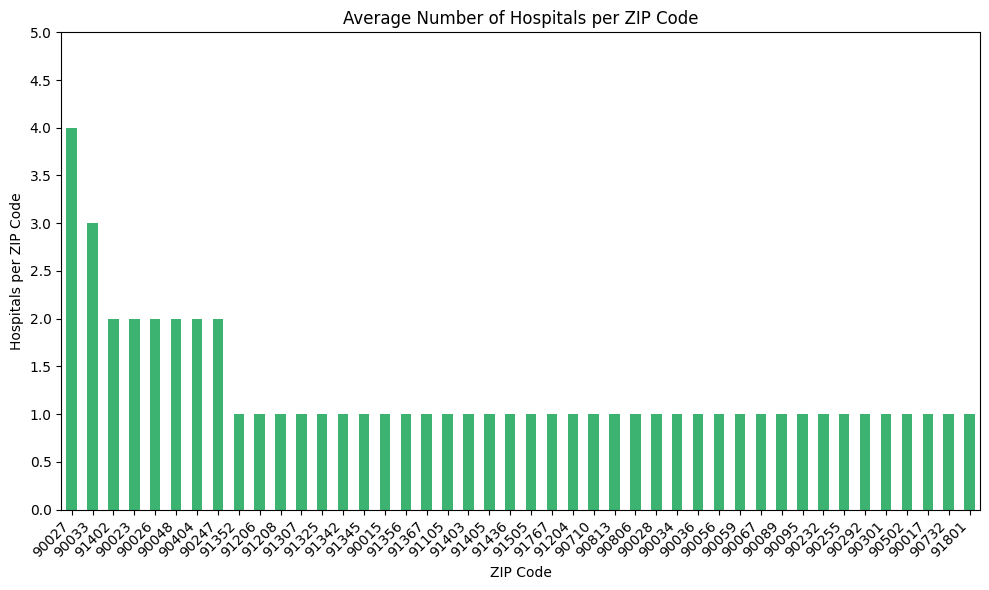

In [102]:
# Group by ZIP code
avg_hospitals = merged_df.groupby('ZIP Code')['hospitals_per_zip'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
avg_hospitals.plot(kind='bar', color='mediumseagreen')

plt.title('Average Number of Hospitals per ZIP Code')
plt.ylabel('Hospitals per ZIP Code')
plt.xlabel('ZIP Code')
plt.xticks(rotation=45, ha='right')

# Add more y-axis ticks (more frequent intervals)
y_min, y_max = plt.ylim()
plt.yticks(np.arange(0, y_max + 1, step=0.5))

plt.tight_layout()
plt.show()

This visualization shows the distribution of hospital density across ZIP codes.
Areas with fewer hospitals may indicate potential disparities in healthcare accessibility relative to crime occurrences.